# Cross Validation

### Jack Bennetto

## Objectives

By the end of the day you should be able to

 * Describe the three kinds of model error
 * State the two ways cross validation is used
 * Explain k-fold cross validation
 * Explain the training, validation, testing data sets

## Agenda

In this lesson we will talk about

* A simple example
* Bias and Variance
* Train-test split
* K-fold cross validation

In [9]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold

## A simple example

Let's plot some data.

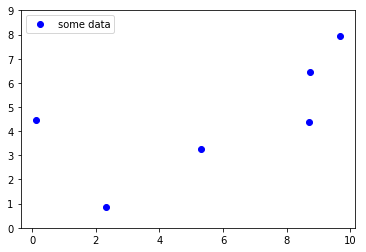

In [2]:
rs=8;npts=6;b0=2;b1=0.5;
x=stats.uniform(0,10).rvs(npts,random_state=rs);
y=b0+b1*x+stats.norm(0,1).rvs(npts, random_state=rs)

fig, ax = plt.subplots()
ax.plot(x, y, 'bo', label='some data')
ax.set_ylim((0, 9))
ax.legend(loc='upper left')

Let's do linear regression!

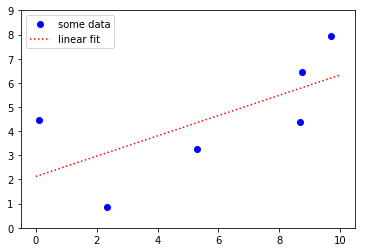

In [3]:
x_col = x[:, None] # convert to column vector, to fit with sklearn
xpts = np.linspace(0,10)[:, None] # points for plotting

model1 = LinearRegression()
model1.fit(x_col, y)
yhat = model1.predict(xpts)
ax.plot(xpts, yhat, 'r:', label="linear fit")
ax.legend(loc='upper left')
fig

I don't know, that looks okay I guess, but it kind of looks quadratic. We can create a pipeline with `PolynomialFeatures`.

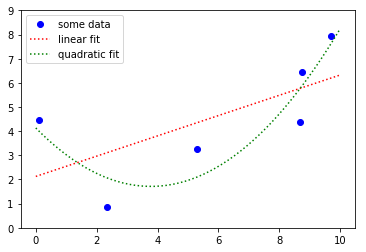

In [4]:
model2 = Pipeline([
        ('pf', PolynomialFeatures(2)),
        ('lr', LinearRegression())
        ])
model2.fit(x_col, y)
yhat = model2.predict(xpts)
ax.plot(xpts, yhat, 'g:', label="quadratic fit")
ax.legend(loc='upper left')
fig

That's better, but let's try a higher-order polynomial.

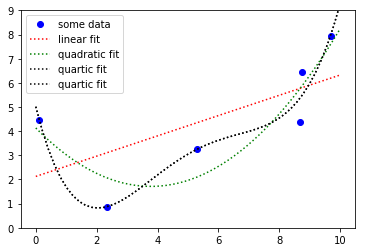

In [6]:
model3 = Pipeline([
        ('pf', PolynomialFeatures(4)),
        ('lr', LinearRegression())
        ])
model3.fit(x_col, y)
yhat = model3.predict(xpts)
ax.plot(xpts, yhat, 'k:', label='quartic fit')
ax.legend(loc='upper left')
fig

That looks great! We did a great job!

So how did we actually generate these points?

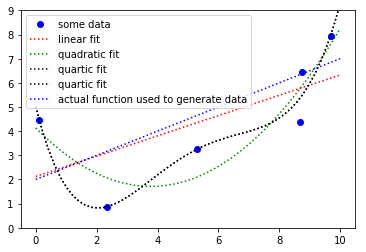

In [7]:
y_actual = b0 + b1 * xpts
ax.plot(xpts, y_actual, 'b:', label='actual function used to generate data')
ax.legend(loc='upper left')
fig

So we went off the rails there.

First, what we did is called **overfitting**, when we fit the specific available data in a way that doesn't generalize to other data. This happens pretty often, whenever we have a very complicated model with many independent parameters. Making our model too complicated is bad.

The opposite, called **underfitting**, is bad too. Suppose we'd just used the mean of the $y$ values to estimate $\hat y$ for all the points. That's too simple of a model.

### Bias and Variance

We'll come back to these again and again and again through the course. The mean-squared error of a model can be decomposed into three components.

1. The **Irreducible error** is the error inherent in any value. Even if we had all possible data and could build a perfect model, we can't predict values exactly.
2. The square of the **Bias** is due to the failure of the model to match our training sample. It's easy to get rid of bias with a complicated model that predicts all the data in our sample exactly.
3. The **Variance** of the model over all possible training sets, which is a measure of how far the training-set model is from the what it would be if trained on all the data. If we had access to entire population of data, we would have no variance.

In general, there is a trade-off between bias and variance. A complex model might have very low bias, but will be highly dependent on the sample taken so will have high variance. A simple model might have higher bias, because it underfits, but lower variance, predicting other data nearly as well as the training sample.

Some models have **hyperparameters** that can be tuned. Most represent that trade-off: moving them in one direction will lower the bias and raise the variance; moving them in the other will do the opposite.

Okay, so how do we tell which model is the best?

### CROSS VALIDATION!

The basic concept behind cross validation is that we the data on which we train our model can't accurately access its effectiveness. That's due to overfitting, that no matter how hard we try to generalize the model, its always based more on the data we used than the data we didn't.

Cross validation really has two separate purposes.

First, it is used for **model comparison**. Over the coming week we'll learn a bunch of different models, and we need to evaluate which will do best for our data. In addition, many of these models have hyperparameters, and we need cross validation to choose the appropriate values. 

Second, it's used to **evaluate your model**. Part of the CRISP-DM is evaluation; you (usually) need to know how well your model will predict real-world results. There are many ways to measure that, like mean-square-error or mean-absolute-error for regression models, or log loss or brier score or AUC/ROC or F-score some combination of precision and recall or sensitivity and specificity, based on your specific business case, but in the end the key thing is that you can't measure it on your training data.


Note: You can measure on your training data in some circumstances, either because your statistical measure allows some estimation of the error, or you have an ensemble model where different submodels see different data (out-of-bag error). But those aren't as general.

## The train-test split

The simplest approach we can use is the train-test split. You probably shouldn't call this cross validation, just say "train-test split" or "hold-out validation."

Let's start with the mtcars dataset that you may have seen before.

In [11]:
import pandas as pd

In [14]:
cars = pd.read_csv('cars.csv')

In [15]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
model           398 non-null int64
origin          398 non-null int64
car_name        398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


There are a few rows without data for horsepower, which is why it shows up as an object. We're just going to throw those away for now without worrying too much if that's okay.

In [16]:
cars = cars[cars.horsepower != '?']
cars.horsepower = cars.horsepower.astype('float128')
cars.mpg = cars.mpg.astype('float128')

Text(0, 0.5, 'horsepower')

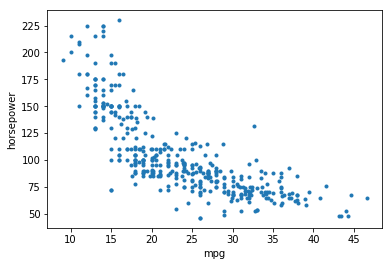

In [17]:
fig, ax = plt.subplots()
ax.plot(cars.mpg, cars.horsepower, '.')
ax.set_xlabel("mpg")
ax.set_ylabel("horsepower")

In [18]:
X = cars[['mpg']]
y = cars.horsepower

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)
print("R^2 on training data: {}".format(model.score(X_train, y_train)))
print("R^2 on testing data:  {}".format(model.score(X_test, y_test)))
                                             

R^2 on training data: 0.6067379548039891
R^2 on testing data:  0.5816981613191659


Okay, we did a bit better on the training data, as expected...or did we?

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)
print("R^2 on training data: {}".format(model.score(X_train, y_train)))
print("R^2 on testing data:  {}".format(model.score(X_test, y_test)))

R^2 on training data: 0.6002234104423954
R^2 on testing data:  0.6200766445741468


Apparently it's pretty sensitive to the random split. Let's explore more.

(0.4, 0.8)

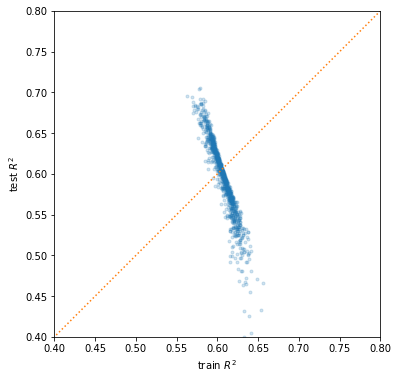

In [22]:
train_score = []
test_score = []
model = LinearRegression()

for _ in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model.fit(X_train, y_train)
    train_score.append(model.score(X_train, y_train))
    test_score.append(model.score(X_test, y_test))
                   
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(train_score, test_score, '.', alpha=0.2)
ax.plot([0, 1], [0, 1], ':')
ax.set_aspect('equal')
ax.set_xlabel('train $R^2$')
ax.set_ylabel('test $R^2$')
ax.set_xlim((.4,.8))
ax.set_ylim((.4,.8))

So we usually do better with the training set. Usually.

Let's see if we can reproduce that train-test-split graph.

In [23]:
def mean_squared_error(model, X, y):
    return np.mean((model.predict(X) - y) **2)

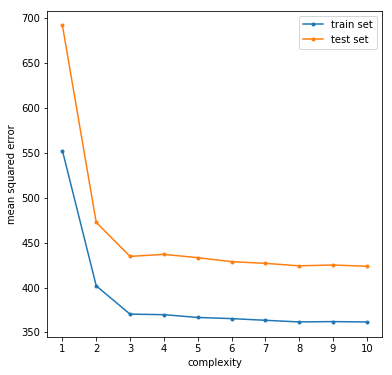

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

train_score = []
test_score = []

for degree in range(1, 11):
    model = Pipeline([
        ('pf', PolynomialFeatures(degree)),
        ('lr', LinearRegression())
        ])
    model.fit(X_train, y_train)
    train_score.append(mean_squared_error(model, X_train, y_train))
    test_score.append(mean_squared_error(model, X_test, y_test))
    #train_score.append(-model.score(X_train, y_train))
    #test_score.append(-model.score(X_test, y_test))

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(range(1, 11), train_score, '.-', label="train set")
ax.plot(range(1, 11), test_score, '.-', label="test set")
ax.set_xlabel('complexity')
ax.set_ylabel('mean squared error')
ax.legend()
ax.set_xticks(range(1, 11))
plt.show()

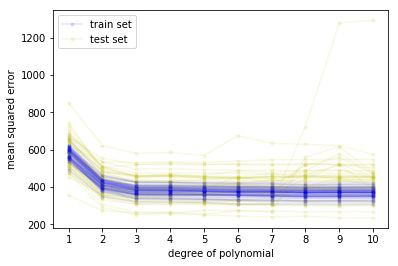

In [25]:
fig, ax = plt.subplots()

for t in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    train_score = []
    test_score = []

    for degree in range(1, 11):
        model = Pipeline([
            ('pf', PolynomialFeatures(degree)),
            ('lr', LinearRegression())
            ])
        model.fit(X_train, y_train)
        train_score.append(mean_squared_error(model, X_train, y_train))
        test_score.append(mean_squared_error(model, X_test, y_test))
        #train_score.append(-model.score(X_train, y_train))
        #test_score.append(-model.score(X_test, y_test))
    if t == 0:
        ax.plot(range(1, 11), train_score, 'b.-', label="train set", alpha=0.1)
        ax.plot(range(1, 11), test_score, 'y.-', label="test set", alpha=0.1)
    else:
        ax.plot(range(1, 11), train_score, 'b.-', alpha=0.1)
        ax.plot(range(1, 11), test_score, 'y.-', alpha=0.1)
        
ax.set_xlabel('degree of polynomial')
ax.set_ylabel('mean squared error')
ax.legend()
ax.set_xticks(range(1, 11))
plt.show()

(40, 240)

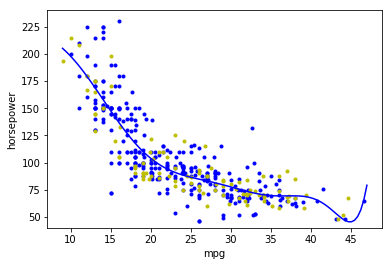

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

fig, ax = plt.subplots()
ax.set_xlabel("mpg")
ax.set_ylabel("horsepower")
ax.plot(X_train, y_train, 'b.')
ax.plot(X_test, y_test, 'y.')


model = Pipeline([
    ('pf', PolynomialFeatures(11)),
    ('lr', LinearRegression())
    ])
model.fit(X_train, y_train)
xpts = np.linspace(9, 47, 100).reshape(-1, 1)
ax.plot(xpts, model.predict(xpts), 'b-')
ax.set_ylim(40, 240)

Overall, this isn't all that consistent. We need something better.

## K-fold Cross Validation

With Cross Validation, we randomly partition the data into $k$ groups, $D_1$, $D_2$, ..., $D_k$. For each $i \in [1..k]$ we:

 * Build a model using $D_{j \ne i}$ as a training data
 * Calculate the error of the model on $D_i$
 
We average all these errors to compute the overall error of the model. We can either compare those across different models to choose the best model or use that number to report the actual error of our model.

There isn't a clear "best" value for $k$. The extreme version of k-fold cross validation, when $k=n$, is called leave-one-out cross validation. That's generally not so good, and $k=2$ is not so good, but experience has shown that other choices are fine. I like $k=5$.

One confusing thing about the `KFold` object in `sklearn` is that it returns indices, not the data themselves.

In [27]:
kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
scores = []

for train, test in kf.split(X):
    model = LinearRegression()
    model.fit(X.values[train], y.values[train])
    scores.append(model.score(X.values[test], y.values[test]))
    
print(np.mean(scores))

0.5819068409320055


Many `sklearn` models include "CV" versions that use cross validation to calculate hyperparameters automatically.

**Stratified cross validation** is a variation in which the partitions are chosen to have similar values for features.

## Overfitting on the testing data

There's a problem with all this. Because the model and hyperparameters are chosen based on the training and testing data, the errors of the model aren't an accurate representation of how it would behave on outside data. If we want to know how it will behave in general, we need to hold out additional data. In this case we have

 * **Training data** are used to fit the model.
 * **Validation data** are used to choose the model and hyperparameters. Once these are determined, these are combined with the training data to re-fit the model.
 * **Testing data** are used to evaluate the final accuracy of the model.
 
For each of these we can use either simple hold-out validation or k-fold cross validation.